# Variation in the crust and core EOS 

In [1]:
import o2sclpy
import matplotlib.pyplot as plot
import ctypes
import numpy
import sys
import random

In [2]:
plots=True
if 'pytest' in sys.modules:
    plots=False

A simple function which tests to ensure that the EOS is monotonic

In [3]:
def test_eos(ve,vp):
    for i in range(0,len(ve)-1):
        if ve[i]>=ve[i+1]:
            return False
        if vp[i]>=vp[i+1]:
            return False
    return True

Link the O$_2$scl library:

In [4]:
link=o2sclpy.linker()
link.link_o2scl()

The O$_2$scl unit conversion object

In [5]:
cu=link.o2scl_settings.get_convert_units()

Create the object which interpolates the EOS for the TOV
solver. Use the default crust EOS.

In [6]:
eti=o2sclpy.eos_tov_interp(link)

Specify the EOS and determine the M-R curve

In [7]:
ts=o2sclpy.tov_solve(link)
ts.verbose=0
ts.set_eos(eti)

Prepare the two-panel plot

Created new axes named subplot0.
Created new axes named subplot1.


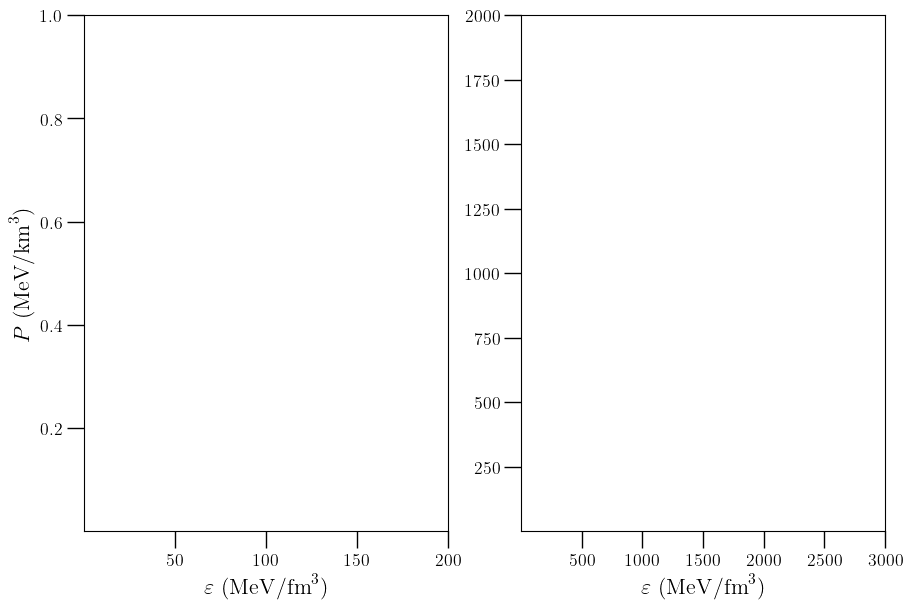

In [8]:
pb=o2sclpy.plot_base()
pb.fig_dict='fig_size_x=9,fig_size_y=6'
pb.subplots(1,2)
plot.subplots_adjust(left=0.10,right=0.99,top=0.98,bottom=0.12,
                     wspace=0.20)
pb.selax('0')
pb.xtitle(r'$ \varepsilon~(\mathrm{MeV}/\mathrm{fm}^3) $')
pb.ytitle(r'$ P~(\mathrm{MeV}/\mathrm{km}^3) $')
pb.xlimits(0.1,2.0e2)
pb.ylimits(2.0e-4,1.0)
pb.selax('1')
pb.xtitle(r'$ \varepsilon~(\mathrm{MeV}/\mathrm{fm}^3) $')
pb.xlimits(0.1,3.0e3)
pb.ylimits(2.0e-4,2.0e3)

Core EOS from the 2021 PRL, first we download the file
(if it's not already stored locally).

In [9]:
cf=o2sclpy.cloud_file(link)
cf.verbose=1
cf.get_file('a21_all_IS_threep_8.o2',
            ('https://isospin.roam.utk.edu/public_data/almamun21/'+
             '3P_GW_all_IS/is_threep_8_out'))

Function cloud_file::get_file_hash() succeeded to obtain file named 'a21_all_IS_threep_8.o2'.


0

Now we read the results table and the fixed energy density grid from
the HDF5 file

In [10]:
print('Reading the file. This takes a bit of time because',
      'it is a large file.')
hf=o2sclpy.hdf_file(link)
a21_tab=o2sclpy.table_units(link)
ug_ed=o2sclpy.uniform_grid(link)
hf.open('a21_all_IS_threep_8.o2')
o2sclpy.hdf_input_table(link,hf,a21_tab,'markov_chain_0')
o2sclpy.hdf_input_uniform_grid(link,hf,ug_ed,'e_grid')
hf.close()
print('Done reading the file. Table has',a21_tab.get_nlines(),'lines.')

Reading the file. This takes a bit of time because it is a large file.
Done reading the file. Table has 124480 lines.


Convert the uniform_grid object to a numpy vector

In [11]:
ug_ed_v=o2sclpy.std_vector(link)
ug_ed.vector(ug_ed_v)
ug_ed_v=ug_ed_v.to_numpy()

Loop over EOSs from the A21 table

In [ ]:
for i_eos in range(0,a21_tab.get_nlines(),
                   int(a21_tab.get_nlines()/100)):

    # Get the EOS from the specified row of the table
    
    a21_eos=o2sclpy.table_units(link)
    a21_eos.line_of_names('ed pr')
    a21_eos.line_of_units('1/fm^4 1/fm^4')
    for i in range(0,100):
        Pi=a21_tab.get('P_'+str(i),i_eos)
        if Pi>0:
            a21_eos.line_of_data([ug_ed_v[i],Pi])

    if a21_eos.get_nlines()>50:
    
        # The maximum mass, as obtained by Mamun using bamr
    
        mmax=a21_tab.get('M_max',i_eos)
    
        # Get a random crust and load the EOS in the eos_tov object

        L=random.random()*80+30
        eti.read_table(a21_eos,'ed','pr')
        eti.ngl13_low_dens_eos(L)
        ve=eti.get_full_vece()
        vp=eti.get_full_vecp()
        
        # Test EOS
        
        if test_eos(ve,vp):

            # Plot EOS
            
            pb.selax('0')
            ve2=[cu.convert('Msun/km^3','MeV/fm^3',ve[i]) for
                 i in range(0,len(ve))]
            vp2=[cu.convert('Msun/km^3','MeV/fm^3',vp[i]) for
                 i in range(0,len(vp))]
            pb.axes.loglog(ve2,vp2)
            pb.selax('1')
            pb.axes.loglog(ve2,vp2)

            # Get M-R curve and maximum mass
            
            ts.mvsr()
        
            print('A21 row %6d, NGL 13 crust, L: %4.3e, M_max: %7.6e' %
                  (i_eos,L,ts.get_results().max('gm')))

A21 row      0, NGL 13 crust, L: 6.094e+01, M_max: 2.136186e+00
A21 row   1244, NGL 13 crust, L: 9.517e+01, M_max: 2.152985e+00
A21 row   2488, NGL 13 crust, L: 8.714e+01, M_max: 2.133703e+00
A21 row   3732, NGL 13 crust, L: 8.118e+01, M_max: 2.061248e+00
A21 row   4976, NGL 13 crust, L: 5.930e+01, M_max: 2.030153e+00
A21 row   6220, NGL 13 crust, L: 5.561e+01, M_max: 2.298663e+00
A21 row   7464, NGL 13 crust, L: 4.457e+01, M_max: 2.127017e+00
A21 row   8708, NGL 13 crust, L: 3.267e+01, M_max: 2.016899e+00
A21 row   9952, NGL 13 crust, L: 4.573e+01, M_max: 2.009696e+00
A21 row  11196, NGL 13 crust, L: 9.925e+01, M_max: 2.257970e+00
A21 row  12440, NGL 13 crust, L: 9.159e+01, M_max: 2.108070e+00
A21 row  13684, NGL 13 crust, L: 1.000e+02, M_max: 2.026185e+00
A21 row  14928, NGL 13 crust, L: 1.005e+02, M_max: 2.192350e+00
A21 row  16172, NGL 13 crust, L: 1.068e+02, M_max: 2.106179e+00
A21 row  17416, NGL 13 crust, L: 5.379e+01, M_max: 2.043211e+00
A21 row  18660, NGL 13 crust, L: 9.889e+

Show all the EOSs

In [ ]:
pb.show()

For testing using ``pytest``:

In [ ]:
def test_fun():
    assert 0==0
    return